# Indoor (rectangles) Dataset Maker
## PhD Research  

**Xiaoshi Wang**<br/>
**11/23/2022**<br/>

<hr style="height:2pt">

In [1]:
#RUN THIS CELL
import os
import pathlib
import random
import matplotlib.pyplot as plt
import time
import shutil
import pathlib
import csv
import glob
working_dir = pathlib.Path().absolute()
os.chdir(working_dir)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from matplotlib import pyplot
import matplotlib.pylab as plt 
%matplotlib inline

In [3]:
from platform import python_version
print("Python version: ", python_version())
print("numpy version: ", np.version.version)

Python version:  3.9.16
numpy version:  1.23.5


In [4]:
# Create DataFrame to store the floor plan boundary: X
def create_int_bnd_matrix(root_path, iter_index, nxy, nz, res):
    room_file_pth = root_path + "design_iteration_" + str(iter_index) + "/" + "design_" + str(iter_index) + "_room.csv"
    open_file_pth = root_path + "design_iteration_" + str(iter_index) + "/" + "design_" + str(iter_index) + "_open.csv"
    # read room data
    rm_file = open(room_file_pth,"r")
    param = list(csv.reader(rm_file, delimiter = ','))[:-1]
    param = np.array(param).astype(float)
    rm_file.close()
    
    op_file = open(open_file_pth,"r")
    openings = list(csv.reader(op_file, delimiter = ','))
    openings = np.array(openings).astype(float)
    op_file.close()
    
    def build_coord_array(opening, resolution):
        xl, xh, yl, yh, zl, zh = opening[0], opening[1], opening[2], opening[3], opening[4], opening[5]
        x_range = np.arange(xl, xh + resolution, resolution)
        y_range = np.arange(yl, yh + resolution, resolution)
        z_range = np.arange(zl, zh + resolution, resolution)
        x_arr, y_arr, z_arr = [], [], []
        for x_i in x_range:
            for y_i in y_range:
                for z_i in z_range:
                    x_arr.append(x_i)
                    y_arr.append(y_i)
                    z_arr.append(z_i)
        return np.array(x_arr), np.array(y_arr), np.array(z_arr)
    
    bnd_list = []
    dxyz_list = []
    for rm_ind in range(len(param)):
        x_ori = np.arange(param[rm_ind][0], param[rm_ind][1]+res, res)
        y_ori = np.arange(param[rm_ind][2], param[rm_ind][3]+res, res)
        z_ori = np.arange(param[rm_ind][4], param[rm_ind][5]+res, res)
        x_ori, y_ori, z_ori = np.meshgrid(x_ori, y_ori, z_ori)
        x_ori, y_ori, z_ori = x_ori.flatten(), y_ori.flatten(), z_ori.flatten()
        u_ori, v_ori, w_ori, p_ori, pat_ori = np.zeros(x_ori.shape), np.zeros(x_ori.shape), np.zeros(x_ori.shape), np.zeros(x_ori.shape), np.zeros(x_ori.shape)
        df_ori = pd.DataFrame({"x":x_ori, "y":y_ori, "z":z_ori, "u":u_ori, "v":v_ori, "w":w_ori, "p":p_ori})
        df_pat_ori = pd.DataFrame({"x":x_ori, "y":y_ori, "z":z_ori, "pattern":pat_ori})
        
        inlet_file = root_path + "design_iteration_" + str(iter_index) + "/" + "design_" + str(iter_index) + "_inlet_uvw_" + str(rm_ind) + ".csv"
        in_df = pd.read_csv(inlet_file)
        in_df = in_df.round({'x': 3, 'y': 3, 'z': 3})
        
        for opening in openings:
            if opening[6] == rm_ind:
                x_array, y_array, z_array = build_coord_array(opening, res)
                for i in range(len(x_array)):
                    df_pat_ori.loc[(df_pat_ori.x == x_array[i]) & (df_pat_ori.y == y_array[i]) & (df_pat_ori.z == z_array[i]), "pattern"] = -1.0
            elif opening[7] == rm_ind:
                x_array, y_array, z_array = build_coord_array(opening, res)
                xl, xh, yl, yh, zl, zh = opening[0], opening[1], opening[2], opening[3], opening[4], opening[5]
                xl, xh = (xl-0.001, xh+0.001) if xl == xh else (xl+0.001, xh-0.001)
                yl, yh = (yl-0.001, yh+0.001) if yl == yh else (yl+0.001, yh-0.001)
                zl, zh = (zl-0.001, zh+0.001) if zl == zh else (zl+0.001, zh-0.001)
                drop_index = df_ori.loc[(df_ori['x'] > xl) & (df_ori['x'] < xh) & (df_ori['y'] > yl) & (df_ori['y'] < yh) & (df_ori['z'] > zl) & (df_ori['z'] < zh)].index
                df_ori.drop(drop_index, inplace=True)
                df_ori.reset_index(drop=True, inplace=True)
                for i in range(len(x_array)):
                    df_pat_ori.loc[(df_pat_ori.x == x_array[i]) & (df_pat_ori.y == y_array[i]) & (df_pat_ori.z == z_array[i]), "pattern"] = 1.0
        for j in range(len(in_df)):
            df_ori.loc[len(df_ori.index)] = [in_df.iloc[j].x, in_df.iloc[j].y, in_df.iloc[j].z, in_df.iloc[j].u, in_df.iloc[j].v, in_df.iloc[j].w, in_df.iloc[j].p]
        
        xi, dx = np.linspace(param[rm_ind][0], param[rm_ind][1], nxy, retstep=True)
        yi, dy = np.linspace(param[rm_ind][2], param[rm_ind][3], nxy, retstep=True)
        zi, dz = np.linspace(param[rm_ind][4], param[rm_ind][5], nz, retstep=True)
        xi, yi, zi = np.meshgrid(xi, yi, zi)
        xi, yi, zi = xi.flatten(), yi.flatten(), zi.flatten()
        
        ui = griddata((df_ori.x, df_ori.y, df_ori.z), df_ori.u, (xi, yi, zi), method='linear')
        vi = griddata((df_ori.x, df_ori.y, df_ori.z), df_ori.v, (xi, yi, zi), method='linear')
        wi = griddata((df_ori.x, df_ori.y, df_ori.z), df_ori.w, (xi, yi, zi), method='linear')
        pi = griddata((df_ori.x, df_ori.y, df_ori.z), df_ori.p, (xi, yi, zi), method='linear')
        pati = griddata((df_pat_ori.x, df_pat_ori.y, df_pat_ori.z), df_pat_ori.pattern, (xi, yi, zi), method='linear')
        
        dfi = pd.DataFrame({"xi":xi, "yi":yi, "zi":zi, "ui":ui, "vi":vi, "wi":wi, "pi":pi, "pati":pati})
        dfi['xi'] = (dfi['xi']-param[rm_ind][0])/dx
        dfi['yi'] = (dfi['yi']-param[rm_ind][2])/dy
        dfi['zi'] = (dfi['zi']-param[rm_ind][4])/dz
        
        dfi = dfi.round({'xi': 0, 'yi': 0, 'zi': 0, 'ui': 6, 'vi': 6, 'wi': 6, 'pi': 6})
        dfi.loc[(dfi['pati'] != 1.0) & (dfi['pati'] != -1.0), 'pati'] = 0.0
        dfi[['xi', 'yi', 'zi']] = dfi[['xi', 'yi', 'zi']].astype(int)
        dfi.loc[((dfi['xi'] == 0.0) | (dfi['xi'] == nxy-1.0)) & ((dfi['yi'] == 0.0) | (dfi['yi'] == nxy-1.0)), 'pati'] = 0.0
        dfi.loc[((dfi['xi'] == 0.0) | (dfi['xi'] == nxy-1.0)) & ((dfi['zi'] == 0.0) | (dfi['zi'] == nz-1.0)), 'pati'] = 0.0
        dfi.loc[((dfi['yi'] == 0.0) | (dfi['yi'] == nxy-1.0)) & ((dfi['zi'] == 0.0) | (dfi['zi'] == nz-1.0)), 'pati'] = 0.0
        
        bnd = np.zeros((nxy, nxy, nz, 5)) # 3 channel: u, v, w, pattern
        bnd[dfi.xi, dfi.yi, dfi.zi, 0] = dfi.ui
        bnd[dfi.xi, dfi.yi, dfi.zi, 1] = dfi.vi
        bnd[dfi.xi, dfi.yi, dfi.zi, 2] = dfi.wi
        bnd[dfi.xi, dfi.yi, dfi.zi, 3] = dfi.pi
        bnd[dfi.xi, dfi.yi, dfi.zi, 4] = dfi.pati
        bnd[1:-1, 1:-1, 1:-1, :4] = 0.0
        bnd[1:-1, 1:-1, 1:-1, 4] = 0.5
        
        bnd = bnd.astype('float32',casting='same_kind')
        bnd_list.append(bnd)
        dxyz = np.array([dx, dy, dz]).astype('float32',casting='same_kind')
        dxyz_list.append(dxyz)
        
    return bnd_list, dxyz_list

In [5]:
# Create DataFrame to store the CFD result pattern: y
def create_int_cfd_matrix(root_path, iter_index, nxy, nz, res):
    room_file_pth = root_path + "design_iteration_" + str(iter_index) + "/" + "design_" + str(iter_index) + "_room.csv"
    open_file_pth = root_path + "design_iteration_" + str(iter_index) + "/" + "design_" + str(iter_index) + "_open.csv"
    # read room data
    rm_file = open(room_file_pth,"r")
    param = list(csv.reader(rm_file, delimiter = ','))[:-1]
    param = np.array(param).astype(float)
    rm_file.close()
    
    op_file = open(open_file_pth,"r")
    openings = list(csv.reader(op_file, delimiter = ','))
    openings = np.array(openings).astype(float)
    op_file.close()
    
    boxes_file_pth = root_path + "design_iteration_" + str(iter_index) + "/west/multizone_" + str(iter_index) + ".csv"
    df = pd.read_csv(boxes_file_pth)
    df = df.drop(columns = "cellnumber").rename(columns={"    x-coordinate": "x", "    y-coordinate": "y", "    z-coordinate": "z", "        pressure": "p", "      x-velocity": "u", "      y-velocity": "v", "      z-velocity": "w"})
    
    all_open_folder = root_path + "design_iteration_" + str(iter_index) + "/all_open_uvw/"
    rm_op_files = [[name for name in os.listdir(all_open_folder) if i in np.array(name.split(".")[0].split("_")[1:]).astype(int)]for i in range(5)]
    
    cfd_list = []
    for rm_ind in range(len(param)):
        inlet_file = root_path + "design_iteration_" + str(iter_index) + "/" + "design_" + str(iter_index) + "_inlet_uvw_" + str(rm_ind) + ".csv"
        in_df = pd.read_csv(inlet_file)
        in_df = in_df.round({'x': 3, 'y': 3, 'z': 3})
        
        rxl, rxh, ryl, ryh, rzl, rzh = float(param[rm_ind][0]), float(param[rm_ind][1]), float(param[rm_ind][2]), float(param[rm_ind][3]), float(param[rm_ind][4]), float(param[rm_ind][5])
        cur_df = df.loc[(df['x'] > rxl) & (df['x'] < rxh) & (df['y'] > ryl) & (df['y'] < ryh) & (df['z'] > rzl) & (df['z'] < rzh)]
        cur_df.reset_index(drop=True, inplace=True)
        cur_df = cur_df.round({'x': 3, 'y': 3, 'z': 3})
        
        x_ori = np.arange(rxl, rxh+res, res)
        y_ori = np.arange(ryl, ryh+res, res)
        z_ori = np.arange(rzl, rzh+res, res)
        x_ori, y_ori, z_ori = np.meshgrid(x_ori, y_ori, z_ori)
        x_ori, y_ori, z_ori = x_ori.flatten(), y_ori.flatten(), z_ori.flatten()
        u_ori, v_ori, w_ori= np.zeros(x_ori.shape), np.zeros(x_ori.shape), np.zeros(x_ori.shape)
        df_bnd = pd.DataFrame({"x":x_ori, "y":y_ori, "z":z_ori, "u":u_ori, "v":v_ori, "w":w_ori})
        center_index = df_bnd.loc[(df_bnd['x'] > rxl+res/2) & (df_bnd['x'] < rxh-res/2) & (df_bnd['y'] > ryl+res/2) & (df_bnd['y'] < ryh-res/2) & (df_bnd['z'] > rzl+res/2) & (df_bnd['z'] < rzh-res/2)].index
        df_bnd.drop(center_index, inplace=True)
        df_bnd.reset_index(drop=True, inplace=True)
        
        for opening in openings:
            if opening[6] == rm_ind or opening[7] == rm_ind: 
                xl, xh, yl, yh, zl, zh = opening[0], opening[1], opening[2], opening[3], opening[4], opening[5]
                xl, xh = (xl-0.001, xh+0.001) if xl == xh else (xl+0.001, xh-0.001)
                yl, yh = (yl-0.001, yh+0.001) if yl == yh else (yl+0.001, yh-0.001)
                zl, zh = (zl-0.001, zh+0.001) if zl == zh else (zl+0.001, zh-0.001)
                drop_index = df_bnd.loc[(df_bnd['x'] > xl) & (df_bnd['x'] < xh) & (df_bnd['y'] > yl) & (df_bnd['y'] < yh) & (df_bnd['z'] > zl) & (df_bnd['z'] < zh)].index
                df_bnd.drop(drop_index, inplace=True)
                df_bnd.reset_index(drop=True, inplace=True)
        
        p_bnd = griddata((cur_df.x, cur_df.y, cur_df.z), cur_df.p, (df_bnd.x, df_bnd.y, df_bnd.z), method='nearest')
        df_bnd["p"] = p_bnd
        
        for file in rm_op_files[rm_ind]:
            df_op = pd.read_csv(all_open_folder + file)
            df_op = df_op.drop(columns = "nodenumber").rename(columns={"    x-coordinate": "x", "    y-coordinate": "y", "    z-coordinate": "z", "        pressure": "p", "      x-velocity": "u", "      y-velocity": "v", "      z-velocity": "w"})
            df_bnd = pd.concat([df_bnd, df_op], ignore_index=True)
        cur_df = pd.concat([cur_df, df_bnd], ignore_index=True)
        
        xi, dx = np.linspace(rxl, rxh, nxy, retstep=True)
        yi, dy = np.linspace(ryl, ryh, nxy, retstep=True)
        zi, dz = np.linspace(rzl, rzh, nz, retstep=True)
        xi, yi, zi = np.meshgrid(xi, yi, zi)
        xi, yi, zi = xi.flatten(), yi.flatten(), zi.flatten()
        
        ui = griddata((cur_df.x, cur_df.y, cur_df.z), cur_df.u, (xi, yi, zi), method='linear')
        vi = griddata((cur_df.x, cur_df.y, cur_df.z), cur_df.v, (xi, yi, zi), method='linear')
        wi = griddata((cur_df.x, cur_df.y, cur_df.z), cur_df.w, (xi, yi, zi), method='linear')
        pi = griddata((cur_df.x, cur_df.y, cur_df.z), cur_df.p, (xi, yi, zi), method='linear')
        
        if np.sum(np.isnan(ui).astype(int)) > 0:
            nan_inds = np.argwhere(np.isnan(ui))
            p_nan = griddata((np.delete(xi, nan_inds, 0), np.delete(yi, nan_inds, 0), np.delete(zi, nan_inds, 0)), np.delete(pi, nan_inds, 0), (xi[nan_inds], yi[nan_inds], zi[nan_inds]), method='nearest')
            ui[nan_inds] = 0.0
            vi[nan_inds] = 0.0
            wi[nan_inds] = 0.0
            pi[nan_inds] = p_nan
            
        dfi = pd.DataFrame({"xi":xi, "yi":yi, "zi":zi, "ui":ui, "vi":vi, "wi":wi, "pi":pi})
        dfi['xi'] = (dfi['xi']-rxl)/dx
        dfi['yi'] = (dfi['yi']-ryl)/dy
        dfi['zi'] = (dfi['zi']-rzl)/dz
        
        dfi = dfi.round({'xi': 0, 'yi': 0, 'zi': 0, 'ui': 6, 'vi': 6, 'wi': 6, 'pi': 6})
        dfi[['xi', 'yi', 'zi']] = dfi[['xi', 'yi', 'zi']].astype(int)
        
        mx = np.zeros((nxy, nxy, nz, 4)) # 3 channel: u, v, w, pattern
        mx[dfi.xi, dfi.yi, dfi.zi, 0] = dfi.ui
        mx[dfi.xi, dfi.yi, dfi.zi, 1] = dfi.vi
        mx[dfi.xi, dfi.yi, dfi.zi, 2] = dfi.wi
        mx[dfi.xi, dfi.yi, dfi.zi, 3] = dfi.pi
        
        mx = mx.astype('float32',casting='same_kind')
        cfd_list.append(mx)
        
        if np.sum(np.isnan(mx).astype(int)) > 0:
            print("Found cfd nan data!: Room# " + str(rm_ind))
    return cfd_list

In [6]:
# root_path = "C:/Users/Xiaoshi/Dropbox/9_PhD_Semester_9/01_PhD_Research/02_Transfer_Learning/00_Data_Generator/CFD_result_data/"
root_path = "E:/00_Data_Generator/CFD_result_data/"
target_path = "C:/Users/Xiaoshi/Dropbox/9_PhD_Semester_9/01_PhD_Research/02_Transfer_Learning/00_Data_Generator/CFD_result_data/"
delta = 0.25
n_xy = 32
n_z = 16
# indices = range(500)
indices = [2636]
for iter_index in indices:
    bnd_mx_list, delta_list = create_int_bnd_matrix(root_path, iter_index, n_xy, n_z, delta)
    cfd_mx_list = create_int_cfd_matrix(root_path, iter_index, n_xy, n_z, delta)
    for i in range(len(bnd_mx_list)): 
        npz_file_name = target_path.replace("CFD_result_data", "Indoor_Dataset_B") + "indoor_iteration_" + str(iter_index*5+i) + ".npz"
        np.savez_compressed(npz_file_name, bnd_mx_list[i], delta_list[i], cfd_mx_list[i])
    print("data point " + str(iter_index) + " complete")

data point 2636 complete


In [6]:
root_path = "C:/Users/Xiaoshi/Dropbox/9_PhD_Semester_9/01_PhD_Research/02_Transfer_Learning/00_Data_Generator/CFD_result_data/"
box_index = 3
folder_path = root_path.replace("CFD_result_data", "Indoor_Dataset_B") + "indoor_iteration_" + str(box_index) + ".npz"
data = np.load(folder_path)
bnd_mx, xyz_deltas, cfd_mx = data['arr_0'], data['arr_1'], data['arr_2']
print("bnd shape  : ", bnd_mx.shape)
print("delta shape: ", xyz_deltas.shape)                                                  
print("cfd shape  : ", cfd_mx.shape)

bnd shape  :  (32, 32, 16, 5)
delta shape:  (3,)
cfd shape  :  (32, 32, 16, 4)


In [7]:
ind_list = []
for box_index in range(2500):
    folder_path = root_path.replace("CFD_result_data", "Indoor_Dataset_B") + "indoor_iteration_" + str(box_index) + ".npz"
    data = np.load(folder_path)
    bnd_mx, xyz_deltas, cfd_mx = data['arr_0'], data['arr_1'], data['arr_2']
    if not np.sum(np.isnan(bnd_mx).astype(int)) == 0 or not np.sum(np.isnan(cfd_mx).astype(int)) == 0:
        ind_list.append(box_index)
        print("index: ", box_index)
        print("bnd: ", np.sum(np.isnan(bnd_mx).astype(int)))
        print("cfd: ", np.sum(np.isnan(cfd_mx).astype(int)))
ind_list

KeyboardInterrupt: 

In [ ]:
np.argwhere(np.isnan(cfd_mx))

dx:  0.16935484
dy:  0.13709678
dz:  0.2


(0.0, 1.0, 0.0, 1.0)

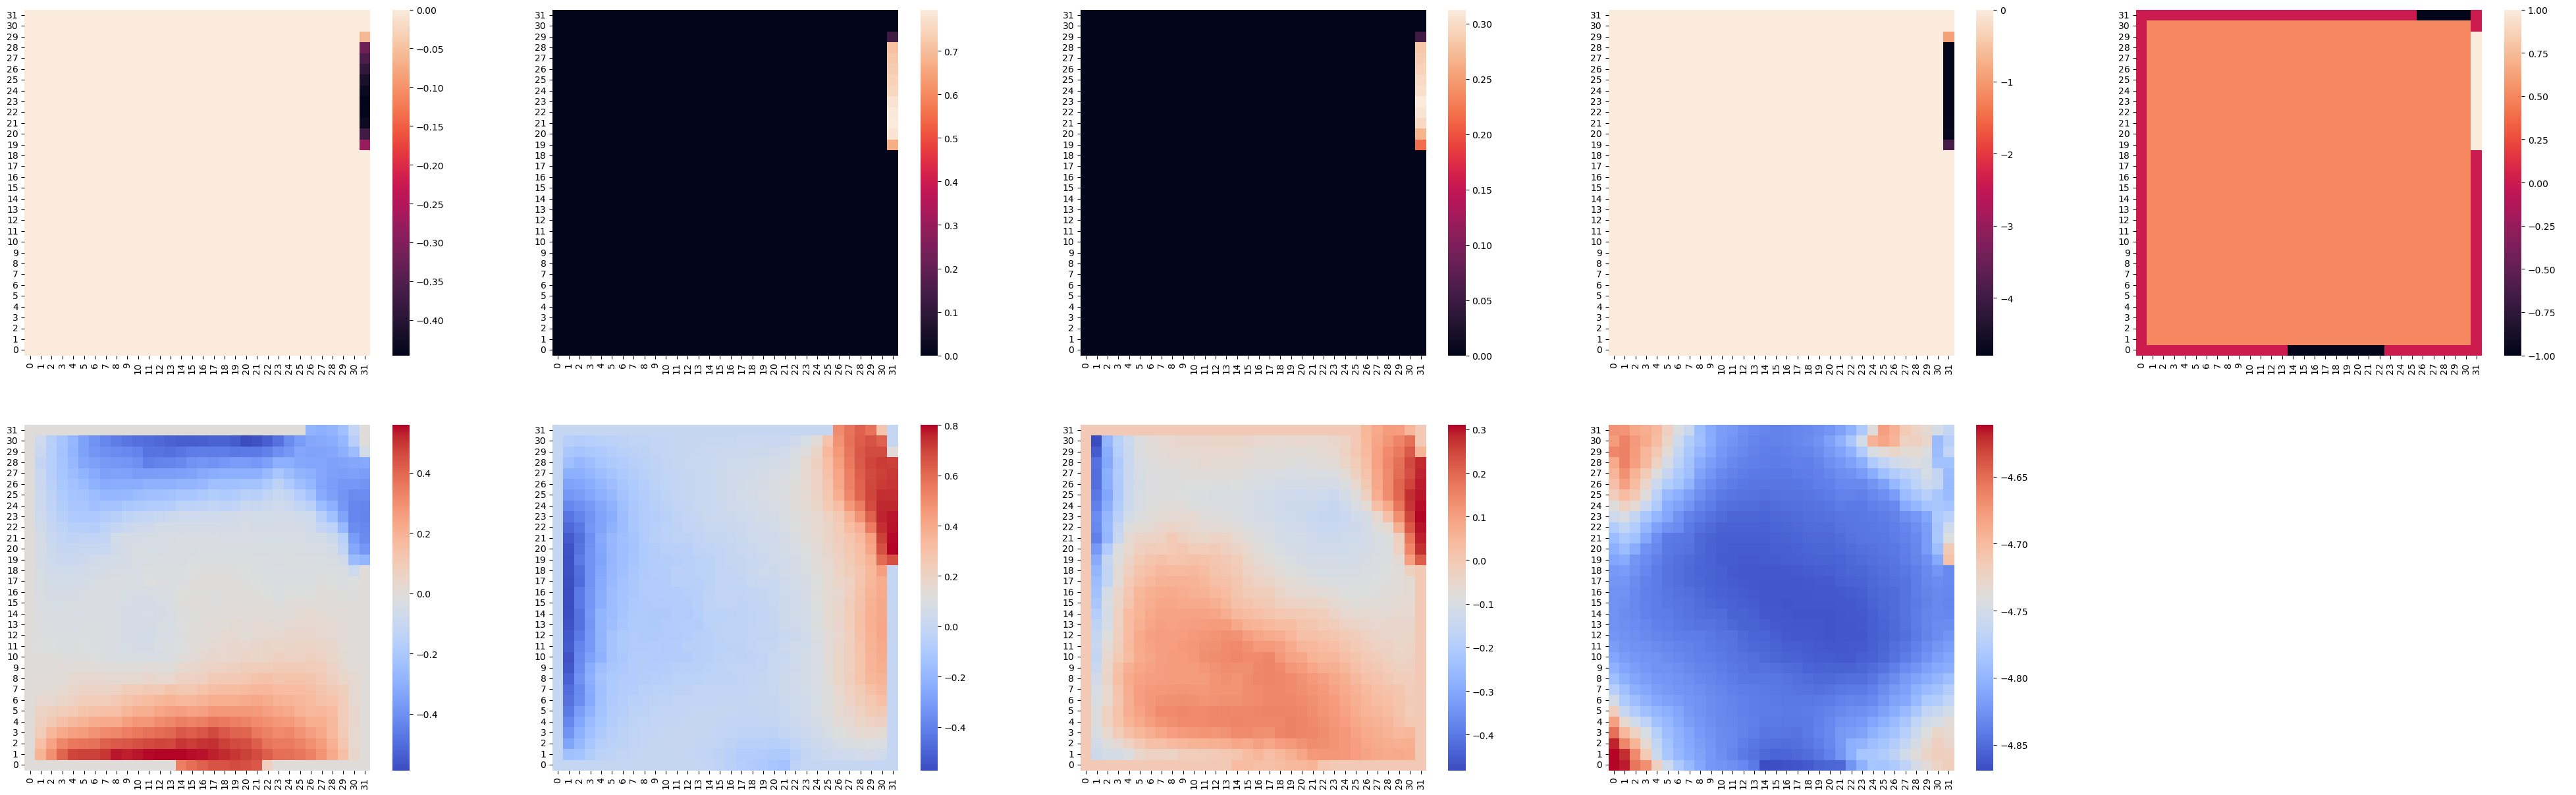

In [8]:
print("dx: ", xyz_deltas[0])
print("dy: ", xyz_deltas[1])
print("dz: ", xyz_deltas[2])
id_z_layer = 8
ub, vb, wb, pb, patb = bnd_mx[:,:,:,0], bnd_mx[:,:,:,1], bnd_mx[:,:,:,2], bnd_mx[:,:,:,3], bnd_mx[:,:,:,4]
uc, vc, wc, pc = cfd_mx[:,:,:,0], cfd_mx[:,:,:,1], cfd_mx[:,:,:,2], cfd_mx[:,:,:,3]

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(50, 15))
sns.heatmap(ub[:,:,id_z_layer].T, ax = ax[0,0], square = True)
ax[0,0].invert_yaxis()
sns.heatmap(vb[:,:,id_z_layer].T, ax = ax[0,1], square = True)
ax[0,1].invert_yaxis()
sns.heatmap(wb[:,:,id_z_layer].T, ax = ax[0,2], square = True)
ax[0,2].invert_yaxis()
sns.heatmap(pb[:,:,id_z_layer].T, ax = ax[0,3], square = True)
ax[0,3].invert_yaxis()
sns.heatmap(patb[:,:,id_z_layer].T, ax = ax[0,4], square = True)
ax[0,4].invert_yaxis()

sns.heatmap(uc[:,:,id_z_layer].T, ax = ax[1,0], square = True, cmap="coolwarm")
ax[1,0].invert_yaxis()
sns.heatmap(vc[:,:,id_z_layer].T, ax = ax[1,1], square = True, cmap="coolwarm")
ax[1,1].invert_yaxis()
sns.heatmap(wc[:,:,id_z_layer].T, ax = ax[1,2], square = True, cmap="coolwarm")
ax[1,2].invert_yaxis()
sns.heatmap(pc[:,:,id_z_layer].T, ax = ax[1,3], square = True, cmap="coolwarm")
ax[1,3].invert_yaxis()
ax[1,4].axis('off')